In [7]:
import sys
import time
from typing import List, Tuple, Set
import heapq

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('../..')
from utils import set_seed, plot_gantt

# Set random seed for reproducibility
set_seed(42)

In [8]:
# Load the scheduling data
schedules_df = pd.read_csv('../../data/schedules.csv')
processing_times = schedules_df['processing_time'].values
release_dates = schedules_df['release_date'].values
n_jobs = len(schedules_df)
print(f"Loaded {n_jobs} jobs")
schedules_df.head()

Loaded 100 jobs


,processing_time,release_date
0,62,0
1,47,1
2,66,2
3,88,4
4,44,18


In [9]:
class BranchAndMemorize:
    """
    A class to solve single-machine scheduling with release dates using Branch-and-Memorize.
    Minimizes TOTAL COMPLETION TIME (sum of completion times), not makespan.

    Attributes:
        p (np.ndarray): Processing times for each job.
        r (np.ndarray): Release dates for each job.
        n (int): Number of jobs.
        best_total_completion (float): The best total completion time found.
        best_sequence (List[int] or None): The sequence that achieves the best objective.
        nodes_explored (int): Number of nodes explored in the search tree.
        state_cache (Dict): Cache for memoization to avoid redundant computation.
    """

    def __init__(self, processing_times: np.ndarray, release_dates: np.ndarray):
        """
        Initializes the BranchAndMemorize instance.

        Args:
            processing_times (np.ndarray): Array of processing times for each job.
            release_dates (np.ndarray): Array of release dates for each job.
        """
        self.p = processing_times
        self.r = release_dates
        self.n = len(processing_times)
        self.best_total_completion = float('inf')
        self.best_sequence = None
        self.nodes_explored = 0

        # Memorization: Cache to store best value for each state
        # Key: (current_time, frozenset of remaining jobs)
        # Value: best total completion time seen for this state
        self.state_cache = {}

    def lower_bound(self, current_time: float, total_completion_so_far: float,
                   remaining: Set[int]) -> float:
        """
        Computes a lower bound using preemptive SRPT relaxation.

        Args:
            current_time (float): Current time in the schedule.
            total_completion_so_far (float): Sum of completion times of scheduled jobs.
            remaining (Set[int]): Set of remaining job indices.

        Returns:
            float: Lower bound on total completion time.
        """
        if not remaining:
            return total_completion_so_far

        # SRPT (Shortest Remaining Processing Time) - preemptive relaxation
        # This gives the tightest lower bound for 1|r_j|sum C_j
        jobs_data = [(self.r[j], self.p[j], j) for j in remaining]
        jobs_data.sort()  # Sort by release date

        t = current_time
        total_comp = total_completion_so_far
        job_queue = []  # Min-heap: (remaining_time, job_id)

        i = 0
        while job_queue or i < len(jobs_data):
            # Add all newly released jobs to queue
            while i < len(jobs_data) and jobs_data[i][0] <= t:
                heapq.heappush(job_queue, (jobs_data[i][1], jobs_data[i][2]))
                i += 1

            if not job_queue:
                # Jump to next release time
                if i < len(jobs_data):
                    t = jobs_data[i][0]
                continue

            # Process job with the shortest remaining time
            p_remain, job_id = heapq.heappop(job_queue)

            # Check if preemption occurs
            if i < len(jobs_data) and t + p_remain > jobs_data[i][0]:
                # Preempt: do partial work until next release
                work_done = jobs_data[i][0] - t
                t = jobs_data[i][0]
                heapq.heappush(job_queue, (p_remain - work_done, job_id))
            else:
                # Complete the job
                t += p_remain
                total_comp += t

        return total_comp

    def branch_and_bound(self) -> Tuple[List[int], float, int]:
        """
        Performs branch-and-bound search with memorization.

        Returns:
            Tuple[List[int], float, int]: Best sequence, total completion time, nodes explored.
        """
        priority_queue = []
        self.nodes_explored = 0

        # Initial node: (lower_bound, total_completion_so_far, current_time, sequence, remaining_jobs)
        initial_lb = self.lower_bound(0, 0, set(range(self.n)))
        heapq.heappush(priority_queue, (
            initial_lb,
            0.0,  # total completion time so far
            0.0,  # current time
            tuple(),  # sequence
            frozenset(range(self.n))  # remaining jobs
        ))

        while priority_queue:
            lower_bound_value, total_completion, current_time, sequence, remaining_jobs = heapq.heappop(priority_queue)
            self.nodes_explored += 1

            # Prune by lower bound
            if lower_bound_value >= self.best_total_completion:
                continue

            # Memorization Check: Have we seen this state before with better value?
            state_key = (current_time, remaining_jobs)
            if state_key in self.state_cache:
                if total_completion >= self.state_cache[state_key]:
                    continue  # This path is dominated

            # Update Cache: Store best value for this state
            self.state_cache[state_key] = total_completion

            # Complete solution found
            if not remaining_jobs:
                if total_completion < self.best_total_completion:
                    self.best_total_completion = total_completion
                    self.best_sequence = list(sequence)
                continue

            # Branch: try scheduling each remaining job
            remaining_set = set(remaining_jobs)
            for job in remaining_set:
                # Calculate new state
                start_time = max(self.r[job], current_time)  # Respects release date
                completion_time = start_time + self.p[job]  # Job completes fully
                new_total_completion = total_completion + completion_time
                new_remaining = remaining_set - {job}
                new_sequence = sequence + (job,)

                # Compute lower bound for new state
                new_lower_bound = self.lower_bound(completion_time, new_total_completion, new_remaining)

                # Only add to queue if not pruned
                if new_lower_bound < self.best_total_completion:
                    heapq.heappush(priority_queue, (
                        new_lower_bound,
                        new_total_completion,
                        completion_time,
                        new_sequence,
                        frozenset(new_remaining)
                    ))

        return self.best_sequence, self.best_total_completion, self.nodes_explored


def solve(processing_times: np.ndarray, release_dates: np.ndarray) -> Tuple[List[int], float, int]:
    """
    Solves the single-machine scheduling problem (1|r_j|sum C_j) using Branch-and-Memorize.

    Args:
        processing_times (np.ndarray): Array of processing times for each job.
        release_dates (np.ndarray): Array of release dates for each job.

    Returns:
        Tuple[List[int], float, int]: Best sequence, total completion time, and nodes explored.
    """
    solver = BranchAndMemorize(processing_times, release_dates)
    best_sequence, best_value, nodes = solver.branch_and_bound()
    return best_sequence, best_value, nodes

best_seq, best_value, nodes = solve(processing_times, release_dates)
print("Best sequence:", best_seq)
print("Total Completion Time (∑C_j):", best_value)
print("Nodes explored:", nodes)

Best sequence: [1, 8, 13, 14, 19, 23, 18, 26, 35, 37, 38, 44, 49, 33, 16, 56, 62, 52, 74, 63, 79, 45, 84, 95, 92, 69, 28, 30, 15, 24, 83, 85, 88, 10, 11, 46, 60, 51, 94, 43, 57, 93, 29, 77, 4, 5, 21, 99, 61, 80, 42, 66, 72, 32, 98, 22, 76, 78, 90, 25, 41, 36, 39, 12, 96, 97, 17, 50, 58, 87, 27, 48, 68, 70, 81, 0, 89, 9, 53, 2, 40, 7, 64, 34, 75, 55, 86, 59, 91, 67, 47, 54, 65, 20, 82, 3, 71, 6, 73, 31]
Total Completion Time (∑C_j): 179550.0
Nodes explored: 22911


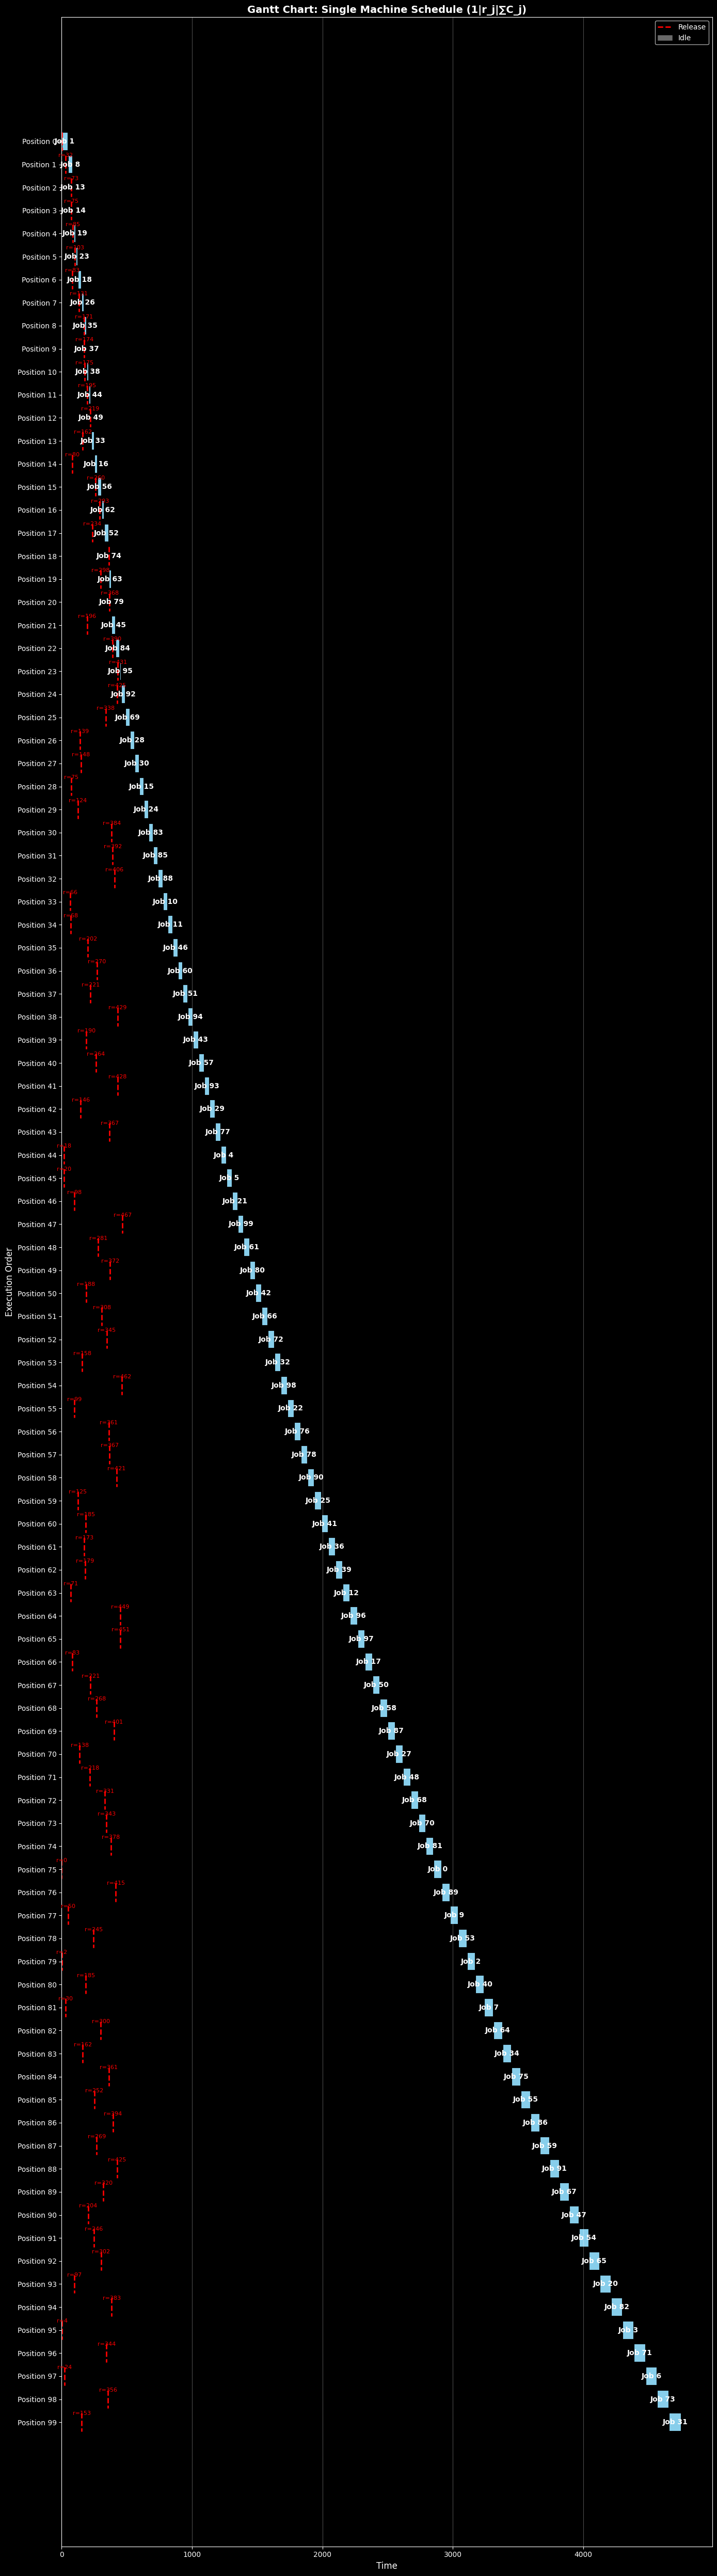

In [4]:
# Visualize the best schedule as a Gantt chart
plot_gantt(best_seq, processing_times, release_dates)

In [10]:
# =============================================================================
# Experiment: Compare 4 Versions of Branch-and-Memorize
# =============================================================================
# 1. Baseline: SRPT bound only
# 2. w/ SPT: SRPT + SPT weighted bound (hybrid lower bound)
# 3. w/ Dominance Rule: SRPT + SPT dominance rule (greedy when all jobs released)
# 4. w/ SPT + Dominance Rule: All optimizations combined
# =============================================================================

class BaselineSolver:
    """Version 1: Baseline - SRPT bound only (same as BranchAndMemorize above)"""
    
    def __init__(self, processing_times: np.ndarray, release_dates: np.ndarray):
        self.p = processing_times
        self.r = release_dates
        self.n = len(processing_times)
        self.best_total_completion = float('inf')
        self.best_sequence = None
        self.nodes_explored = 0
        self.state_cache = {}

    def lower_bound(self, current_time: float, total_completion_so_far: float,
                   remaining: Set[int]) -> float:
        """SRPT preemptive relaxation bound"""
        if not remaining:
            return total_completion_so_far

        jobs_data = [(self.r[j], self.p[j], j) for j in remaining]
        jobs_data.sort()

        t = current_time
        total_comp = total_completion_so_far
        job_queue = []

        i = 0
        while job_queue or i < len(jobs_data):
            while i < len(jobs_data) and jobs_data[i][0] <= t:
                heapq.heappush(job_queue, (jobs_data[i][1], jobs_data[i][2]))
                i += 1

            if not job_queue:
                if i < len(jobs_data):
                    t = jobs_data[i][0]
                continue

            p_remain, job_id = heapq.heappop(job_queue)

            if i < len(jobs_data) and t + p_remain > jobs_data[i][0]:
                work_done = jobs_data[i][0] - t
                t = jobs_data[i][0]
                heapq.heappush(job_queue, (p_remain - work_done, job_id))
            else:
                t += p_remain
                total_comp += t

        return total_comp

    def branch_and_bound(self) -> Tuple[List[int], float, int]:
        priority_queue = []
        self.nodes_explored = 0

        initial_lb = self.lower_bound(0, 0, set(range(self.n)))
        heapq.heappush(priority_queue, (initial_lb, 0.0, 0.0, tuple(), frozenset(range(self.n))))

        while priority_queue:
            lb_val, total_comp, curr_time, seq, remaining = heapq.heappop(priority_queue)
            self.nodes_explored += 1

            if lb_val >= self.best_total_completion:
                continue

            state_key = (curr_time, remaining)
            if state_key in self.state_cache:
                if total_comp >= self.state_cache[state_key]:
                    continue
            self.state_cache[state_key] = total_comp

            if not remaining:
                if total_comp < self.best_total_completion:
                    self.best_total_completion = total_comp
                    self.best_sequence = list(seq)
                continue

            remaining_set = set(remaining)
            for job in remaining_set:
                start = max(self.r[job], curr_time)
                completion = start + self.p[job]
                new_total = total_comp + completion
                new_remaining = remaining_set - {job}
                new_seq = seq + (job,)
                new_lb = self.lower_bound(completion, new_total, new_remaining)

                if new_lb < self.best_total_completion:
                    heapq.heappush(priority_queue, (new_lb, new_total, completion, new_seq, frozenset(new_remaining)))

        return self.best_sequence, self.best_total_completion, self.nodes_explored


class SolverWithSPTBound:
    """Version 2: w/ SPT - SRPT + SPT weighted bound (hybrid)"""
    
    def __init__(self, processing_times: np.ndarray, release_dates: np.ndarray):
        self.p = processing_times
        self.r = release_dates
        self.n = len(processing_times)
        self.best_total_completion = float('inf')
        self.best_sequence = None
        self.nodes_explored = 0
        self.state_cache = {}

    def _srpt_bound(self, current_time: float, total_completion_so_far: float,
                    remaining: Set[int]) -> float:
        """SRPT preemptive relaxation bound"""
        jobs_data = [(self.r[j], self.p[j], j) for j in remaining]
        jobs_data.sort()

        t = current_time
        total_comp = total_completion_so_far
        job_queue = []

        i = 0
        while job_queue or i < len(jobs_data):
            while i < len(jobs_data) and jobs_data[i][0] <= t:
                heapq.heappush(job_queue, (jobs_data[i][1], jobs_data[i][2]))
                i += 1

            if not job_queue:
                if i < len(jobs_data):
                    t = jobs_data[i][0]
                continue

            p_remain, job_id = heapq.heappop(job_queue)

            if i < len(jobs_data) and t + p_remain > jobs_data[i][0]:
                work_done = jobs_data[i][0] - t
                t = jobs_data[i][0]
                heapq.heappush(job_queue, (p_remain - work_done, job_id))
            else:
                t += p_remain
                total_comp += t

        return total_comp

    def _spt_weighted_bound(self, current_time: float, total_completion_so_far: float,
                            remaining: Set[int]) -> float:
        """Position-weighted SPT bound"""
        remaining_times = sorted([self.p[j] for j in remaining])
        n_remaining = len(remaining_times)
        weighted_sum = sum((n_remaining - k) * remaining_times[k] for k in range(n_remaining))
        min_release = min(self.r[j] for j in remaining)
        min_start = max(current_time, min_release)
        return total_completion_so_far + weighted_sum + n_remaining * min_start

    def lower_bound(self, current_time: float, total_completion_so_far: float,
                   remaining: Set[int]) -> float:
        """Hybrid bound: max(SRPT, SPT weighted)"""
        if not remaining:
            return total_completion_so_far
        srpt = self._srpt_bound(current_time, total_completion_so_far, remaining)
        spt = self._spt_weighted_bound(current_time, total_completion_so_far, remaining)
        return max(srpt, spt)

    def branch_and_bound(self) -> Tuple[List[int], float, int]:
        priority_queue = []
        self.nodes_explored = 0

        initial_lb = self.lower_bound(0, 0, set(range(self.n)))
        heapq.heappush(priority_queue, (initial_lb, 0.0, 0.0, tuple(), frozenset(range(self.n))))

        while priority_queue:
            lb_val, total_comp, curr_time, seq, remaining = heapq.heappop(priority_queue)
            self.nodes_explored += 1

            if lb_val >= self.best_total_completion:
                continue

            state_key = (curr_time, remaining)
            if state_key in self.state_cache:
                if total_comp >= self.state_cache[state_key]:
                    continue
            self.state_cache[state_key] = total_comp

            if not remaining:
                if total_comp < self.best_total_completion:
                    self.best_total_completion = total_comp
                    self.best_sequence = list(seq)
                continue

            remaining_set = set(remaining)
            for job in remaining_set:
                start = max(self.r[job], curr_time)
                completion = start + self.p[job]
                new_total = total_comp + completion
                new_remaining = remaining_set - {job}
                new_seq = seq + (job,)
                new_lb = self.lower_bound(completion, new_total, new_remaining)

                if new_lb < self.best_total_completion:
                    heapq.heappush(priority_queue, (new_lb, new_total, completion, new_seq, frozenset(new_remaining)))

        return self.best_sequence, self.best_total_completion, self.nodes_explored


class SolverWithDominance:
    """Version 3: w/ Dominance Rule - SRPT + SPT dominance (greedy when all released)"""
    
    def __init__(self, processing_times: np.ndarray, release_dates: np.ndarray):
        self.p = processing_times
        self.r = release_dates
        self.n = len(processing_times)
        self.best_total_completion = float('inf')
        self.best_sequence = None
        self.nodes_explored = 0
        self.state_cache = {}

    def lower_bound(self, current_time: float, total_completion_so_far: float,
                   remaining: Set[int]) -> float:
        """SRPT preemptive relaxation bound"""
        if not remaining:
            return total_completion_so_far

        jobs_data = [(self.r[j], self.p[j], j) for j in remaining]
        jobs_data.sort()

        t = current_time
        total_comp = total_completion_so_far
        job_queue = []

        i = 0
        while job_queue or i < len(jobs_data):
            while i < len(jobs_data) and jobs_data[i][0] <= t:
                heapq.heappush(job_queue, (jobs_data[i][1], jobs_data[i][2]))
                i += 1

            if not job_queue:
                if i < len(jobs_data):
                    t = jobs_data[i][0]
                continue

            p_remain, job_id = heapq.heappop(job_queue)

            if i < len(jobs_data) and t + p_remain > jobs_data[i][0]:
                work_done = jobs_data[i][0] - t
                t = jobs_data[i][0]
                heapq.heappush(job_queue, (p_remain - work_done, job_id))
            else:
                t += p_remain
                total_comp += t

        return total_comp

    def _all_released(self, current_time: float, remaining: Set[int]) -> bool:
        return all(self.r[j] <= current_time for j in remaining)

    def _solve_spt(self, current_time: float, total_comp: float, seq: tuple, remaining: Set[int]):
        """When all jobs released, SPT order is optimal"""
        sorted_jobs = sorted(remaining, key=lambda j: self.p[j])
        t = current_time
        total = total_comp
        final_seq = list(seq)
        for job in sorted_jobs:
            t += self.p[job]
            total += t
            final_seq.append(job)
        return final_seq, total

    def branch_and_bound(self) -> Tuple[List[int], float, int]:
        priority_queue = []
        self.nodes_explored = 0

        initial_lb = self.lower_bound(0, 0, set(range(self.n)))
        heapq.heappush(priority_queue, (initial_lb, 0.0, 0.0, tuple(), frozenset(range(self.n))))

        while priority_queue:
            lb_val, total_comp, curr_time, seq, remaining = heapq.heappop(priority_queue)
            self.nodes_explored += 1

            if lb_val >= self.best_total_completion:
                continue

            state_key = (curr_time, remaining)
            if state_key in self.state_cache:
                if total_comp >= self.state_cache[state_key]:
                    continue
            self.state_cache[state_key] = total_comp

            if not remaining:
                if total_comp < self.best_total_completion:
                    self.best_total_completion = total_comp
                    self.best_sequence = list(seq)
                continue

            remaining_set = set(remaining)

            # Dominance Rule: If all jobs released, use SPT directly
            if self._all_released(curr_time, remaining_set):
                spt_seq, spt_total = self._solve_spt(curr_time, total_comp, seq, remaining_set)
                if spt_total < self.best_total_completion:
                    self.best_total_completion = spt_total
                    self.best_sequence = spt_seq
                continue

            for job in remaining_set:
                start = max(self.r[job], curr_time)
                completion = start + self.p[job]
                new_total = total_comp + completion
                new_remaining = remaining_set - {job}
                new_seq = seq + (job,)
                new_lb = self.lower_bound(completion, new_total, new_remaining)

                if new_lb < self.best_total_completion:
                    heapq.heappush(priority_queue, (new_lb, new_total, completion, new_seq, frozenset(new_remaining)))

        return self.best_sequence, self.best_total_completion, self.nodes_explored


class SolverWithSPTAndDominance:
    """Version 4: w/ SPT + Dominance Rule - All optimizations combined"""
    
    def __init__(self, processing_times: np.ndarray, release_dates: np.ndarray):
        self.p = processing_times
        self.r = release_dates
        self.n = len(processing_times)
        self.best_total_completion = float('inf')
        self.best_sequence = None
        self.nodes_explored = 0
        self.state_cache = {}

    def _srpt_bound(self, current_time: float, total_completion_so_far: float,
                    remaining: Set[int]) -> float:
        """SRPT preemptive relaxation bound"""
        jobs_data = [(self.r[j], self.p[j], j) for j in remaining]
        jobs_data.sort()

        t = current_time
        total_comp = total_completion_so_far
        job_queue = []

        i = 0
        while job_queue or i < len(jobs_data):
            while i < len(jobs_data) and jobs_data[i][0] <= t:
                heapq.heappush(job_queue, (jobs_data[i][1], jobs_data[i][2]))
                i += 1

            if not job_queue:
                if i < len(jobs_data):
                    t = jobs_data[i][0]
                continue

            p_remain, job_id = heapq.heappop(job_queue)

            if i < len(jobs_data) and t + p_remain > jobs_data[i][0]:
                work_done = jobs_data[i][0] - t
                t = jobs_data[i][0]
                heapq.heappush(job_queue, (p_remain - work_done, job_id))
            else:
                t += p_remain
                total_comp += t

        return total_comp

    def _spt_weighted_bound(self, current_time: float, total_completion_so_far: float,
                            remaining: Set[int]) -> float:
        """Position-weighted SPT bound"""
        remaining_times = sorted([self.p[j] for j in remaining])
        n_remaining = len(remaining_times)
        weighted_sum = sum((n_remaining - k) * remaining_times[k] for k in range(n_remaining))
        min_release = min(self.r[j] for j in remaining)
        min_start = max(current_time, min_release)
        return total_completion_so_far + weighted_sum + n_remaining * min_start

    def lower_bound(self, current_time: float, total_completion_so_far: float,
                   remaining: Set[int]) -> float:
        """Hybrid bound: max(SRPT, SPT weighted)"""
        if not remaining:
            return total_completion_so_far
        srpt = self._srpt_bound(current_time, total_completion_so_far, remaining)
        spt = self._spt_weighted_bound(current_time, total_completion_so_far, remaining)
        return max(srpt, spt)

    def _all_released(self, current_time: float, remaining: Set[int]) -> bool:
        return all(self.r[j] <= current_time for j in remaining)

    def _solve_spt(self, current_time: float, total_comp: float, seq: tuple, remaining: Set[int]):
        """When all jobs released, SPT order is optimal"""
        sorted_jobs = sorted(remaining, key=lambda j: self.p[j])
        t = current_time
        total = total_comp
        final_seq = list(seq)
        for job in sorted_jobs:
            t += self.p[job]
            total += t
            final_seq.append(job)
        return final_seq, total

    def branch_and_bound(self) -> Tuple[List[int], float, int]:
        priority_queue = []
        self.nodes_explored = 0

        initial_lb = self.lower_bound(0, 0, set(range(self.n)))
        heapq.heappush(priority_queue, (initial_lb, 0.0, 0.0, tuple(), frozenset(range(self.n))))

        while priority_queue:
            lb_val, total_comp, curr_time, seq, remaining = heapq.heappop(priority_queue)
            self.nodes_explored += 1

            if lb_val >= self.best_total_completion:
                continue

            state_key = (curr_time, remaining)
            if state_key in self.state_cache:
                if total_comp >= self.state_cache[state_key]:
                    continue
            self.state_cache[state_key] = total_comp

            if not remaining:
                if total_comp < self.best_total_completion:
                    self.best_total_completion = total_comp
                    self.best_sequence = list(seq)
                continue

            remaining_set = set(remaining)

            # Dominance Rule: If all jobs released, use SPT directly
            if self._all_released(curr_time, remaining_set):
                spt_seq, spt_total = self._solve_spt(curr_time, total_comp, seq, remaining_set)
                if spt_total < self.best_total_completion:
                    self.best_total_completion = spt_total
                    self.best_sequence = spt_seq
                continue

            for job in remaining_set:
                start = max(self.r[job], curr_time)
                completion = start + self.p[job]
                new_total = total_comp + completion
                new_remaining = remaining_set - {job}
                new_seq = seq + (job,)
                new_lb = self.lower_bound(completion, new_total, new_remaining)

                if new_lb < self.best_total_completion:
                    heapq.heappush(priority_queue, (new_lb, new_total, completion, new_seq, frozenset(new_remaining)))

        return self.best_sequence, self.best_total_completion, self.nodes_explored

In [11]:
# =============================================================================
# Run Benchmark: 10, 20, 30, ..., 100 jobs
# =============================================================================

job_sizes = list(range(10, 101, 10))

# Store results for each version
results = {
    'Baseline': {'time': [], 'nodes': [], 'total_completion': []},
    'w/ SPT Bound': {'time': [], 'nodes': [], 'total_completion': []},
    'w/ Dominance': {'time': [], 'nodes': [], 'total_completion': []},
    'w/ SPT + Dom': {'time': [], 'nodes': [], 'total_completion': []},
}

solvers = {
    'Baseline': BaselineSolver,
    'w/ SPT Bound': SolverWithSPTBound,
    'w/ Dominance': SolverWithDominance,
    'w/ SPT + Dom': SolverWithSPTAndDominance,
}

print("=" * 100)
print("Benchmark: Comparing 4 Versions of Branch-and-Memorize")
print("=" * 100)

for n in job_sizes:
    print(f"\n{'='*100}")
    print(f"Testing with {n} jobs...")
    print(f"{'='*100}")
    print(f"{'Version':<20} | {'Time (s)':>12} | {'Nodes':>12} | {'Total Completion':>18}")
    print("-" * 70)
    
    p = processing_times[:n]
    r = release_dates[:n]
    
    for name, SolverClass in solvers.items():
        start = time.time()
        solver = SolverClass(p, r)
        seq, total_comp, nodes = solver.branch_and_bound()
        elapsed = time.time() - start
        
        results[name]['time'].append(elapsed)
        results[name]['nodes'].append(nodes)
        results[name]['total_completion'].append(total_comp)
        
        print(f"{name:<20} | {elapsed:>12.4f} | {nodes:>12,} | {total_comp:>18,.0f}")

print("\n" + "=" * 100)
print("Benchmark Complete!")
print("=" * 100)

Benchmark: Comparing 4 Versions of Branch-and-Memorize

Testing with 10 jobs...
Version              |     Time (s) |        Nodes |   Total Completion
----------------------------------------------------------------------
Baseline             |       0.0005 |           63 |              2,910
w/ SPT Bound         |       0.0007 |           63 |              2,910
w/ Dominance         |       0.0002 |           20 |              2,910
w/ SPT + Dom         |       0.0003 |           20 |              2,910

Testing with 20 jobs...
Version              |     Time (s) |        Nodes |   Total Completion
----------------------------------------------------------------------
Baseline             |       0.0026 |          231 |              7,290
w/ SPT Bound         |       0.0041 |          231 |              7,290
w/ Dominance         |       0.0007 |           40 |              7,290
w/ SPT + Dom         |       0.0010 |           40 |              7,290

Testing with 30 jobs...
Version 

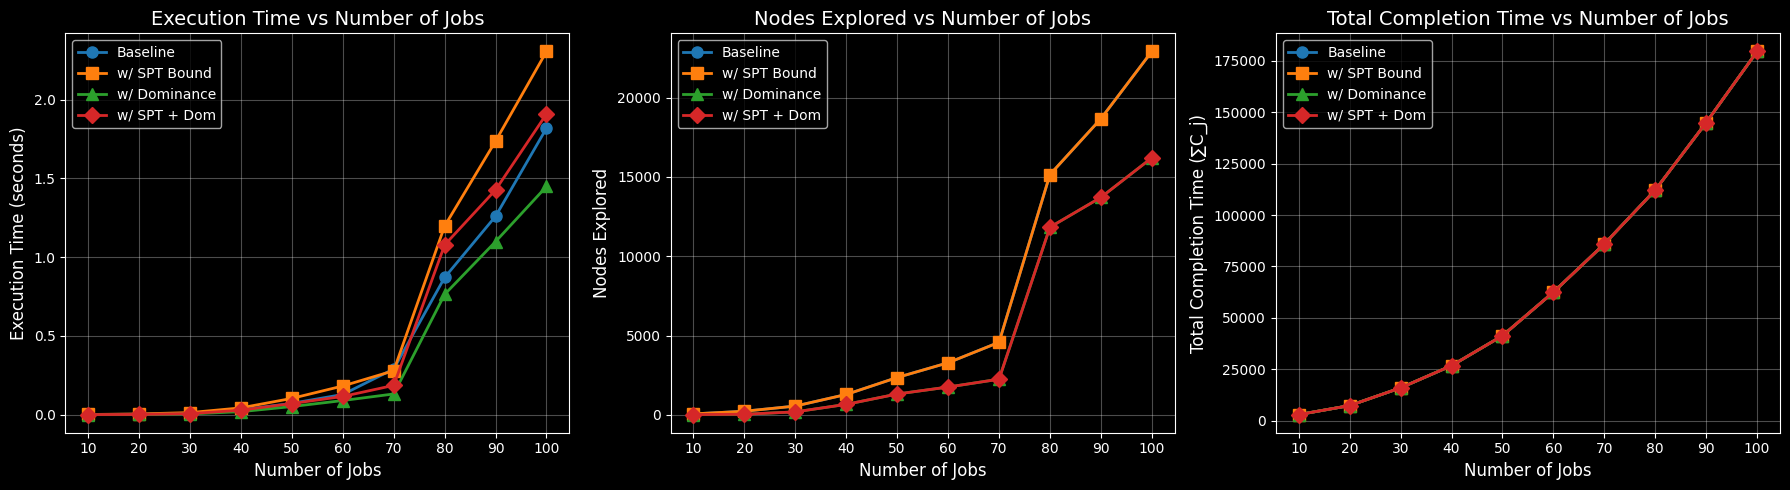


Summary Table: Improvement over Baseline
  Jobs |  Baseline Time |       SPT Time |       Dom Time |   SPT+Dom Time | Best Speedup
------------------------------------------------------------------------------------------------------------------------
    10 |        0.0005s |        0.0007s |        0.0002s |        0.0003s |        2.25x
    20 |        0.0026s |        0.0041s |        0.0007s |        0.0010s |        3.51x
    30 |        0.0087s |        0.0127s |        0.0044s |        0.0061s |        1.97x
    40 |        0.0299s |        0.0428s |        0.0186s |        0.0280s |        1.60x
    50 |        0.0715s |        0.1030s |        0.0511s |        0.0703s |        1.40x
    60 |        0.1279s |        0.1818s |        0.0893s |        0.1152s |        1.43x
    70 |        0.2897s |        0.2785s |        0.1311s |        0.1856s |        2.21x
    80 |        0.8709s |        1.1977s |        0.7634s |        1.0775s |        1.14x
    90 |        1.2594s |  

In [15]:
# =============================================================================
# Plot Results: Execution Time, Nodes Explored, Total Completion Time
# =============================================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
markers = ['o', 's', '^', 'D']

# Plot 1: Execution Time
ax1 = axes[0]
for idx, (name, data) in enumerate(results.items()):
    ax1.plot(job_sizes, data['time'], marker=markers[idx], color=colors[idx], 
             label=name, linewidth=2, markersize=8)
ax1.set_xlabel('Number of Jobs', fontsize=12)
ax1.set_ylabel('Execution Time (seconds)', fontsize=12)
ax1.set_title('Execution Time vs Number of Jobs', fontsize=14)
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(job_sizes)

# Plot 2: Nodes Explored
ax2 = axes[1]
for idx, (name, data) in enumerate(results.items()):
    ax2.plot(job_sizes, data['nodes'], marker=markers[idx], color=colors[idx], 
             label=name, linewidth=2, markersize=8)
ax2.set_xlabel('Number of Jobs', fontsize=12)
ax2.set_ylabel('Nodes Explored', fontsize=12)
ax2.set_title('Nodes Explored vs Number of Jobs', fontsize=14)
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)
ax2.set_xticks(job_sizes)

# Plot 3: Total Completion Time (should be same for all - verification)
ax3 = axes[2]
for idx, (name, data) in enumerate(results.items()):
    ax3.plot(job_sizes, data['total_completion'], marker=markers[idx], color=colors[idx], 
             label=name, linewidth=2, markersize=8)
ax3.set_xlabel('Number of Jobs', fontsize=12)
ax3.set_ylabel('Total Completion Time (∑C_j)', fontsize=12)
ax3.set_title('Total Completion Time vs Number of Jobs', fontsize=14)
ax3.legend(loc='upper left')
ax3.grid(True, alpha=0.3)
ax3.set_xticks(job_sizes)

plt.tight_layout()
plt.show()

# Print summary table
print("\n" + "=" * 120)
print("Summary Table: Improvement over Baseline")
print("=" * 120)
print(f"{'Jobs':>6} | {'Baseline Time':>14} | {'SPT Time':>14} | {'Dom Time':>14} | {'SPT+Dom Time':>14} | {'Best Speedup':>12}")
print("-" * 120)

for i, n in enumerate(job_sizes):
    baseline_time = results['Baseline']['time'][i]
    spt_time = results['w/ SPT Bound']['time'][i]
    dom_time = results['w/ Dominance']['time'][i]
    both_time = results['w/ SPT + Dom']['time'][i]
    best_time = min(spt_time, dom_time, both_time)
    speedup = baseline_time / best_time if best_time > 0 else float('inf')
    
    print(f"{n:>6} | {baseline_time:>13.4f}s | {spt_time:>13.4f}s | {dom_time:>13.4f}s | {both_time:>13.4f}s | {speedup:>11.2f}x")